# Data Collection and Exploration
This notebook loads, explores, and splits the cherry leaves dataset for mildew detection.

In [8]:
# Change working directory to the notebook's parent directory
import os
os.chdir(os.path.dirname(os.path.abspath("../jupyter_notebooks/DataCollection.ipynb")))
print(f"Current working directory: {os.getcwd()}")

Current working directory: /workspaces/mildew-detector/jupyter_notebooks


In [9]:
# Import required libraries
import os
import random
import shutil
from glob import glob
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from collections import Counter

## Define dataset paths
Set the paths for healthy and powdery mildew images.

In [10]:
# Set dataset directories
data_dir = '../data/cherry-leaves'
healthy_dir = os.path.join(data_dir, 'healthy')
mildew_dir = os.path.join(data_dir, 'powdery_mildew')

## Count images in each class
Check the number of images for each class.

In [11]:
healthy_images = glob(os.path.join(healthy_dir, '*.JPG'))
mildew_images = glob(os.path.join(mildew_dir, '*.JPG'))
print(f'Healthy images: {len(healthy_images)}')
print(f'Powdery mildew images: {len(mildew_images)}')

Healthy images: 2104
Powdery mildew images: 2104


## Visualize sample images
Display a few random images from each class.

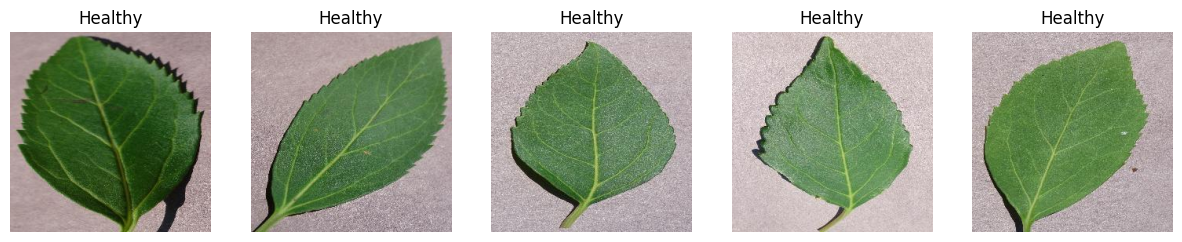

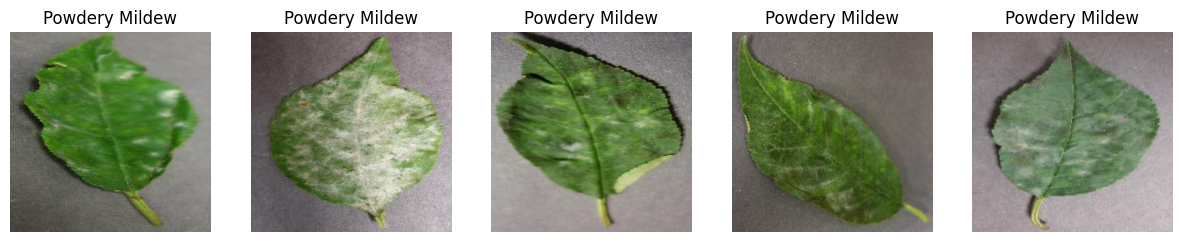

In [12]:
def show_samples(image_list, title, n=5):
    plt.figure(figsize=(15,3))
    for i, img_path in enumerate(random.sample(image_list, n)):
        img = Image.open(img_path)
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(title)
    plt.show()

show_samples(healthy_images, 'Healthy', n=5)
show_samples(mildew_images, 'Powdery Mildew', n=5)

## Split dataset into train, validation, and test sets
Organize images into train (70%), val (15%), and test (15%) folders.

In [13]:
def split_and_copy(images, out_dir, split_fracs=(0.7, 0.15, 0.15)):
    random.shuffle(images)
    n = len(images)
    n_train = int(split_fracs[0] * n)
    n_val = int(split_fracs[1] * n)
    train, val, test = images[:n_train], images[n_train:n_train+n_val], images[n_train+n_val:]
    for split, split_images in zip(['train', 'val', 'test'], [train, val, test]):
        split_dir = os.path.join(out_dir, split)
        os.makedirs(split_dir, exist_ok=True)
        for img_path in split_images:
            shutil.copy(img_path, split_dir)
    return len(train), len(val), len(test)

# Output directories
output_base = '../data/split'
for label, images in [('healthy', healthy_images), ('powdery_mildew', mildew_images)]:
    out_dir = os.path.join(output_base, label)
    n_train, n_val, n_test = split_and_copy(images, out_dir)
    print(f'{label}: train={n_train}, val={n_val}, test={n_test}')

healthy: train=1472, val=315, test=317
powdery_mildew: train=1472, val=315, test=317
powdery_mildew: train=1472, val=315, test=317


## Data Augmentation
To increase the diversity of the training data, we will use image augmentation techniques such as rotation, flipping, and zooming.

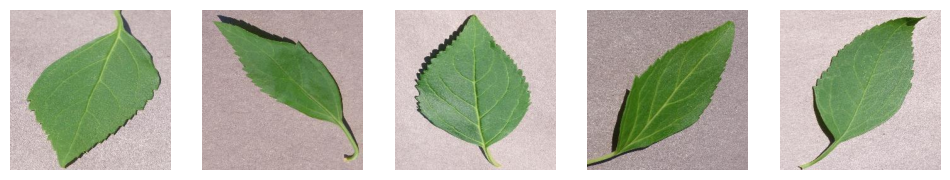

In [15]:
# Update sample_dir to point to the new split location
sample_dir = '../data/split/healthy/train'

# Display a few sample images from the split data
sample_images = glob(os.path.join(sample_dir, '*.JPG'))
plt.figure(figsize=(12, 6))
for i, img_path in enumerate(sample_images[:5]):
    img = Image.open(img_path)
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

Original image counts: {'healthy': 2104, 'powdery_mildew': 2104}
Train set counts after split/augmentation: {'healthy': 1916, 'powdery_mildew': 1898}


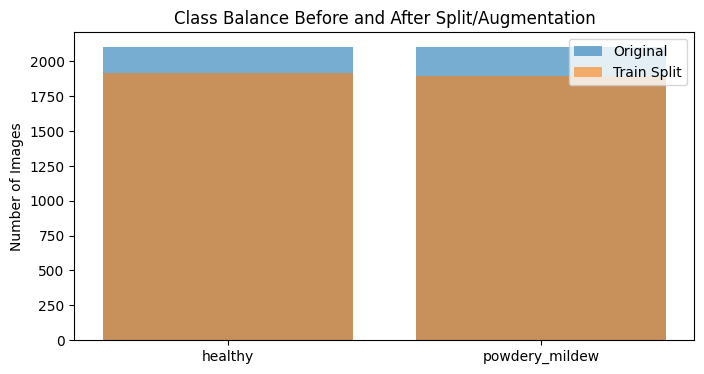

In [16]:
# Show class balance before and after augmentation
from collections import Counter

# Count original images
orig_counts = {'healthy': len(healthy_images), 'powdery_mildew': len(mildew_images)}

# Count images in split/train after augmentation (if augmentation was saved, otherwise just count train images)
train_healthy = glob(os.path.join('../data/split/healthy/train', '*.JPG'))
train_mildew = glob(os.path.join('../data/split/powdery_mildew/train', '*.JPG'))
aug_counts = {'healthy': len(train_healthy), 'powdery_mildew': len(train_mildew)}

print('Original image counts:', orig_counts)
print('Train set counts after split/augmentation:', aug_counts)

# Visualize class balance
plt.figure(figsize=(8,4))
plt.bar(orig_counts.keys(), orig_counts.values(), alpha=0.6, label='Original')
plt.bar(aug_counts.keys(), aug_counts.values(), alpha=0.6, label='Train Split')
plt.ylabel('Number of Images')
plt.title('Class Balance Before and After Split/Augmentation')
plt.legend()
plt.show()